# Inception (Google LeNet)

In [14]:
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np

from d2l.tensorflow import config, data, plot

config.setup('GPU')

Tensorflow running on GPU


## Inception Block

In [15]:
class InceptionBlock(layers.Layer):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(InceptionBlock, self).__init__(**kwargs)
        # Path 1 is a 1 x 1 conv layer
        self.p1_1 = layers.Conv2D(c1, kernel_size=1, activation='relu')
        # Path 2 is a 1 x 1 conv layer followed by a 3 x 3 conv layer
        self.p2_1 = layers.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_pad = layers.ZeroPadding2D(1)
        self.p2_2 = layers.Conv2D(c2[1], kernel_size=3, activation='relu')
        # Path 3 is a 1 x 1 conv layer followed by a 5 x 5 conv layer
        self.p3_1 = layers.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_pad =  layers.ZeroPadding2D(2)
        self.p3_2 = layers.Conv2D(c3[1], kernel_size=5, activation='relu')

        # Path 4 is a 3 x 3 max pool layer followed by a 1 x 1 conv layer
        self.p4_pad = layers.ZeroPadding2D(1)
        self.p4_1 = layers.MaxPool2D(3, strides=1)
        self.p4_2 = layers.Conv2D(c4, kernel_size=1, activation='relu')
    
    def call(self, inputs):
        p1 = self.p1_1(inputs)
        p2 = self.p2_2(self.p2_pad(self.p2_1(inputs)))
        p3 = self.p3_2(self.p3_pad(self.p3_1(inputs)))
        p4 = self.p4_2(self.p4_1(self.p4_pad(inputs)))
        return layers.Concatenate(axis=-1)([p1, p2, p3, p4])

### Inception stage 1

In [16]:
stage1 = models.Sequential()
stage1._name = "stage_1"

stage1.add(layers.ZeroPadding2D(3))
stage1.add(layers.Conv2D(64, kernel_size=7, strides=2, activation='relu'))
stage1.add(layers.ZeroPadding2D(1))
stage1.add(layers.MaxPool2D(3, strides=2))

### Inception stage 2

In [17]:
stage2 = models.Sequential()
stage2._name = "stage_2"

stage2.add(layers.Conv2D(64, kernel_size=1, activation='relu'))
stage2.add(layers.ZeroPadding2D(1))
stage2.add(layers.Conv2D(192, kernel_size=3, strides=2, activation='relu'))
stage2.add(layers.ZeroPadding2D(1))
stage2.add(layers.MaxPool2D(3, strides=2))

### Inception stage 3

In [18]:
stage3 = models.Sequential()
stage3._name = "stage_3"

stage3.add(InceptionBlock(64, (96, 128), (16, 32), 32))
stage3.add(InceptionBlock(128, (128, 192), (32, 96), 64))
stage3.add(layers.ZeroPadding2D(1))
stage3.add(layers.MaxPool2D(3, strides=2))

### Inception stage 4

In [19]:
stage4 = models.Sequential()
stage4._name = "stage_4"

stage4.add(InceptionBlock(192, (96, 208), (16, 48), 64))
stage4.add(InceptionBlock(160, (112, 224), (24, 64), 64))
stage4.add(InceptionBlock(128, (128, 256), (24, 64), 64))
stage4.add(InceptionBlock(112, (144, 288), (32, 64), 64))
stage4.add(InceptionBlock(256, (160, 320), (32, 128), 128))
stage4.add(layers.ZeroPadding2D(1))
stage4.add(layers.MaxPool2D(3, strides=2))

### Inception stage 5

In [20]:
stage5 = models.Sequential()
stage5._name = "stage_5"

stage5.add(InceptionBlock(256, (160, 320), (32, 128), 128))
stage5.add(InceptionBlock(384, (192, 384), (48, 128), 128))
stage5.add(layers.GlobalAvgPool2D())

## Inception Model

In [21]:
inception = models.Sequential()

for stage in (stage1, stage2, stage3, stage4, stage5):
    inception.add(stage)

inception.add(layers.Dense(10, activation='softmax'))

inception.build((None, 96, 96, 1))

In [22]:
X = np.random.uniform(size=(1, 96, 96, 1)).astype(np.float32)

for layer in inception.layers:
    X = layer(X)
    print('{} output shape: {}'.format(layer.name, X.shape))

stage_1 output shape: (1, 24, 24, 64)
stage_2 output shape: (1, 6, 6, 192)
stage_3 output shape: (1, 3, 3, 480)
stage_4 output shape: (1, 2, 2, 832)
stage_5 output shape: (1, 1024)
dense_1 output shape: (1, 10)


In [23]:
inception.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stage_1 (Sequential)         multiple                  3200      
_________________________________________________________________
stage_2 (Sequential)         multiple                  114944    
_________________________________________________________________
stage_3 (Sequential)         multiple                  552432    
_________________________________________________________________
stage_4 (Sequential)         multiple                  2809168   
_________________________________________________________________
stage_5 (Sequential)         multiple                  2487536   
_________________________________________________________________
dense_1 (Dense)              multiple                  10250     
Total params: 5,977,530
Trainable params: 5,977,530
Non-trainable params: 0
___________________________________________

## Training

In [24]:
batch_size = 128
epochs = 5
learning_rate = 0.1

optmizer = keras.optimizers.SGD(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()
metric = keras.metrics.CategoricalAccuracy()

inception.compile(optimizer=optmizer, loss=loss, metrics=metric)

In [25]:
X_train, y_train, X_test, y_test = data.load_fashion_mnist_keras()

resize = [96, 96]
train_iter = data.resize_images_generator(X_train, y_train, batch_size, resize)
test_iter = data.resize_images_generator(X_test, y_test, batch_size, resize)

train_steps = len(X_train) // batch_size + 1
val_steps = len(X_test) // batch_size + 1

In [26]:
hist = inception.fit(
    train_iter, epochs=epochs, validation_data=test_iter, 
    steps_per_epoch=train_steps, validation_steps=val_steps
)

Epoch 1/5
469/469 [==============================] - 83s 177ms/step - loss: 2.2955 - categorical_accuracy: 0.1426 - val_loss: 2.2699 - val_categorical_accuracy: 0.1281
Epoch 2/5
469/469 [==============================] - 79s 168ms/step - loss: 2.1268 - categorical_accuracy: 0.2017 - val_loss: 1.6200 - val_categorical_accuracy: 0.3448
Epoch 3/5
469/469 [==============================] - 80s 170ms/step - loss: 0.7721 - categorical_accuracy: 0.7065 - val_loss: 0.6486 - val_categorical_accuracy: 0.7626
Epoch 4/5
469/469 [==============================] - 80s 170ms/step - loss: 0.4452 - categorical_accuracy: 0.8341 - val_loss: 0.4164 - val_categorical_accuracy: 0.8438
Epoch 5/5
469/469 [==============================] - 80s 170ms/step - loss: 0.3651 - categorical_accuracy: 0.8635 - val_loss: 0.3787 - val_categorical_accuracy: 0.8566


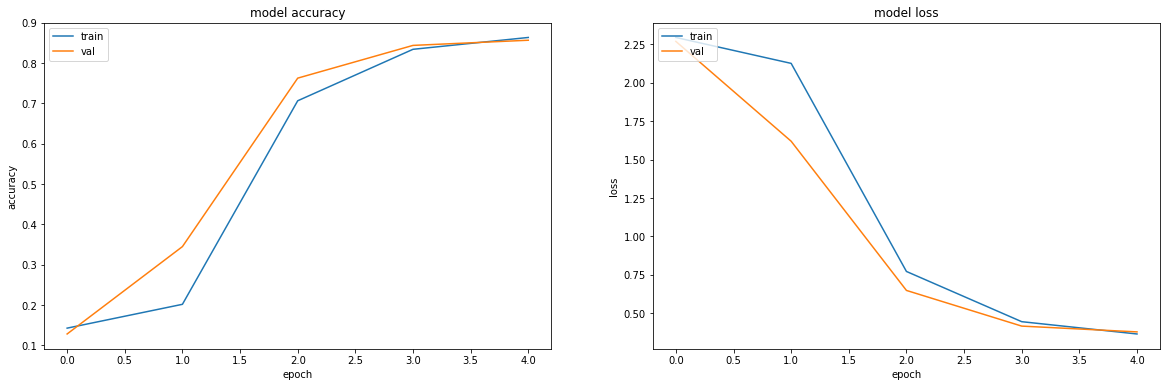

In [27]:
plot.plot_history(hist, 'categorical_accuracy')